# Group A Programming Assignment 4 Report

**Authors:** Aidnel M Martínez Meléndez, Alex Demel Pacheco, Edgar J Suárez-Colón  
**Course:** ICOM5015-001D Artificial Intelligence

## Task Division

| Task            | Group Member      |
|:-----------------:|:-------------------:|
| Programming     | Alex Demel        |
| Debugging       | Edgar Suarez      |
| Report Writing  | Aidnel Martínez   |
| Report Editing  | Edgar Suarez      |
| Video Scripting | Aidnel Martínez   |
| Video Editing   | Alex Demel        |

## I. Introduction
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;This report delves into an in-depth exploration of advanced search algorithms, extending beyond classical methods to include variants of hill climbing and simulated annealing. Our primary objective is to assess the efficiency of these algorithms by evaluating their search costs and effectiveness in identifying solutions. By comparing these findings against the cost of optimal solutions, we aim to discern the most effective algorithm for specific problem contexts. This analysis is crucial for future computer engineers, as it broadens our arsenal of problem-solving methodologies and introduces us to metrics for algorithm selection tailored to various computational challenges.

## II. Exercises

#### **Exercise 4.4**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;This excercise involves generating multiple instances of the 8-puzzle and N-Queens problems to solve them using various search strategies: hill climbing with steepest ascent, hill climbing with random restarts, first choice hill climbing, and simulated annealing. The objective is to evaluate and compare the search cost and success rate of each algorithm. Performance metrics will be visually presented against the cost of optimal solutions, offering a graphical comparison of each algorithm's efficiency and effectiveness. This analysis will highlight the viability and optimization capabilities of each strategy in solving complex problems.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;To fulfill this objective, we must develop representations for the 8-puzzle and 8-queens problems, alongside implementations of the search algorithms under consideration. To streamline this process and concentrate on the analytical aspects demanded by the exercise, we have drawn upon the representations and methodologies outlined in Norvig and Russell's textbook on Artificial Intelligence [1]. Furthermore, the implementations for these algorithms have been sourced directly from the UC Berkeley's code repository [2], ensuring a solid foundation for our analysis. The implementation of these crucial components is presented below:

**Note:** If code fails to run, execute the following command
```pip install --upgrade asttokens```


In [1]:
import sys
import heapq
import random
import numpy as np
from collections import defaultdict
from itertools import combinations

class Node:
    """A node in a search tree. Contains a pointer to the parent (the node
    that this is a successor of) and to the actual state for this node. Note
    that if a state is arrived at by two paths, then there are two nodes with
    the same state. Also includes the action that got us to this state, and
    the total path_cost (also known as g) to reach the node. Other functions
    may add an f and h value; see best_first_graph_search and astar_search for
    an explanation of how the f and h values are handled. You will not need to
    subclass this class."""

    def __init__(self, state, parent=None, action=None, path_cost=0):
        """Create a search tree Node, derived from a parent by an action."""
        self.state = state
        self.parent = parent
        self.action = action
        self.path_cost = path_cost
        self.depth = 0
        if parent:
            self.depth = parent.depth + 1

    def __repr__(self):
        return "<Node {}>".format(self.state)

    def __lt__(self, node):
        return self.state < node.state

    def expand(self, problem):
        """List the nodes reachable in one step from this node."""
        return [self.child_node(problem, action)
                for action in problem.actions(self.state)]

    def child_node(self, problem, action):
        """[Figure 3.10]"""
        next_state = problem.result(self.state, action)
        next_node = Node(next_state, self, action, problem.path_cost(self.path_cost, self.state, action, next_state))
        return next_node

    def solution(self):
        """Return the sequence of actions to go from the root to this node."""
        return [node.action for node in self.path()[1:]]

    def path(self):
        """Return a list of nodes forming the path from the root to this node."""
        node, path_back = self, []
        while node:
            path_back.append(node)
            node = node.parent
        return list(reversed(path_back))

    # We want for a queue of nodes in breadth_first_graph_search or
    # astar_search to have no duplicated states, so we treat nodes
    # with the same state as equal. [Problem: this may not be what you
    # want in other contexts.]

    def __eq__(self, other):
        return isinstance(other, Node) and self.state == other.state

    def __hash__(self):
        # We use the hash value of the state
        # stored in the node instead of the node
        # object itself to quickly search a node
        # with the same state in a Hash Table
        return hash(self.state)

class PriorityQueue:
    """A queue in which the item with minimum f(item) is always popped first."""

    def __init__(self, items=(), key=lambda x: x): 
        self.key = key
        self.items = [] # a heap of (score, item) pairs
        for item in items:
            self.add(item)
         
    def add(self, item):
        """Add item to the queuez."""
        pair = (self.key(item), item)
        heapq.heappush(self.items, pair)

    def pop(self):
        """Pop and return the item with min f(item) value."""
        return heapq.heappop(self.items)[1]
    
    def top(self): return self.items[0][1]

    def __len__(self): return len(self.items)

class Problem:
    """The abstract class for a formal problem. You should subclass
    this and implement the methods actions and result, and possibly
    __init__, goal_test, and path_cost. Then you will create instances
    of your subclass and solve them with the various search functions."""

    def __init__(self, initial, goal=None):
        """The constructor specifies the initial state, and possibly a goal
        state, if there is a unique goal. Your subclass's constructor can add
        other arguments."""
        self.initial = initial
        self.goal = goal

    def actions(self, state):
        """Return the actions that can be executed in the given
        state. The result would typically be a list, but if there are
        many actions, consider yielding them one at a time in an
        iterator, rather than building them all at once."""
        raise NotImplementedError

    def result(self, state, action):
        """Return the state that results from executing the given
        action in the given state. The action must be one of
        self.actions(state)."""
        raise NotImplementedError

    def goal_test(self, state):
        """Return True if the state is a goal. The default method compares the
        state to self.goal or checks for state in self.goal if it is a
        list, as specified in the constructor. Override this method if
        checking against a single self.goal is not enough."""
        if isinstance(self.goal, list):
            return is_in(state, self.goal)
        else:
            return state == self.goal

    def path_cost(self, c, state1, action, state2):
        """Return the cost of a solution path that arrives at state2 from
        state1 via action, assuming cost c to get up to state1. If the problem
        is such that the path doesn't matter, this function will only look at
        state2. If the path does matter, it will consider c and maybe state1
        and action. The default method costs 1 for every step in the path."""
        return c + 1

    def value(self, state):
        """For optimization problems, each state has a value. Hill Climbing
        and related algorithms try to maximize this value."""
        raise NotImplementedError

class NQueensProblem(Problem):
    """The problem of placing N queens on an NxN board with none attacking
    each other. A state is represented as an N-element array, where
    a value of r in the c-th entry means there is a queen at column c,
    row r, and a value of -1 means that the c-th column has not been
    filled in yet. We fill in columns left to right.
    >>> depth_first_tree_search(NQueensProblem(8))
    <Node (7, 3, 0, 2, 5, 1, 6, 4)>
    """

    def __init__(self, N):
        super().__init__(tuple([-1] * N))
        self.N = N

    def actions(self, state):
        """Actions for placing and moving queens."""
        if state[-1] == -1:  # Check if any column is not filled
            col = state.index(-1)
            actions = [row for row in range(self.N) if not self.conflicted(state, row, col)]
            return actions
        else:  # All columns are filled; return actions for moving any queen
            actions = []
            for col in range(self.N):
                for row in range(self.N):
                    if row != state[col] and not self.conflicted(state, row, col, exclude_col=col):
                        actions.append((col, row))
            return actions

    def result(self, state, action):
        """Place queens on empty columns or move existing queens."""
        if isinstance(action, int):
            col = state.index(-1)
            new_state = list(state[:])
            new_state[col] = action
        else:
            col, row = action
            new_state = list(state[:])
            new_state[col] = row
        return tuple(new_state)

    def conflicted(self, state, row, col, exclude_col=None):
        """Would placing a queen at (row, col) conflict with anything?
        Optionally exclude checking against a specific column."""
        return any(self.conflict(row, col, state[c], c)
                   for c in range(self.N) if c != exclude_col and c != col and state[c] != -1)

    def conflict(self, row1, col1, row2, col2):
        """Would putting two queens in (row1, col1) and (row2, col2) conflict?"""
        return (row1 == row2 or  # same row
                col1 == col2 or  # same column
                row1 - col1 == row2 - col2 or  # same \ diagonal
                row1 + col1 == row2 + col2)  # same / diagonal

    def goal_test(self, state):
        """Check if all columns filled, no conflicts."""
        if state[-1] == -1:
            return False
        return not any(self.conflicted(state, state[col], col)
                       for col in range(len(state)))
    
    def random_state(self):
        self.initial = np.random.choice(range(8), size=8, replace=True)
        return self

    def h(self, node):
        """Return number of conflicting queens for a given node"""
        num_conflicts = 0
        for (r1, c1) in enumerate(node.state):
            for (r2, c2) in enumerate(node.state):
                if (r1, c1) != (r2, c2):
                    num_conflicts += self.conflict(r1, c1, r2, c2)

        return num_conflicts
    
    def value(self, node):
        """Value of a node is the negative of the heuristic since we're minimizing conflicts."""
        return -self.h(node)

class Board(defaultdict):
    empty = '.'
    off = '#'
    def __init__(self, board=None, width=8, height=8, to_move=None, **kwds):
        if board is not None:
            self.update(board)
            self.width, self.height = (board.width, board.height) 
        else:
            self.width, self.height = (width, height)
        self.to_move = to_move

    def __missing__(self, key):
        x, y = key
        if x < 0 or x >= self.width or y < 0 or y >= self.height:
            return self.off
        else:
            return self.empty
        
    def __repr__(self):
        def row(y): return ' '.join(self[x, y] for x in range(self.width))
        return '\n'.join(row(y) for y in range(self.height))
            
    def __hash__(self): 
        return hash(tuple(sorted(self.items()))) + hash(self.to_move)

class EightPuzzle(Problem):
    """ The problem of sliding tiles numbered from 1 to 8 on a 3x3 board,
    where one of the squares is a blank, trying to reach a goal configuration.
    A board state is represented as a tuple of length 9, where the element at index i 
    represents the tile number at index i, or 0 if for the empty square, e.g. the goal:
        1 2 3
        4 5 6 ==> (1, 2, 3, 4, 5, 6, 7, 8, 0)
        7 8 _
    """

    def __init__(self, initial, goal=(1, 2, 3, 4, 5, 6, 7, 8, 0)):
        assert inversions(initial) % 2 == inversions(goal) % 2 # Parity check
        self.initial, self.goal = initial, goal
    
    def actions(self, state):
        """The indexes of the squares that the blank can move to."""
        moves = ((1, 3),    (0, 2, 4),    (1, 5),
                 (0, 4, 6), (1, 3, 5, 7), (2, 4, 8),
                 (3, 7),    (4, 6, 8),    (7, 5))
        blank = state.index(0)
        return moves[blank]
    
    def result(self, state, action):
        """Swap the blank with the square numbered `action`."""
        s = list(state)
        blank = state.index(0)
        s[action], s[blank] = s[blank], s[action]
        return tuple(s)

    def goal_test(self, state):
        """ Given a state, return True if state is a goal state or False, otherwise """
        return state == self.goal

    def random_state(self):
        return random_8puzzle()
    
    def h(self, node):
        """The Manhattan heuristic."""
        X = (0, 1, 2, 0, 1, 2, 0, 1, 2)
        Y = (0, 0, 0, 1, 1, 1, 2, 2, 2)
        return sum(abs(X[s] - X[g]) + abs(Y[s] - Y[g])
                   for (s, g) in zip(node.state, self.goal) if s != 0)
    
    def value(self, node):
        """Value of a node is the negative of the heuristic since we're minimizing misplaced tiles."""
        return -self.h(node)

identity = lambda x: x

def inversions(board):
    "The number of times a piece is a smaller number than a following piece."
    return sum((a > b and a != 0 and b != 0) for (a, b) in combinations(board, 2))

def probability(p):
    """Return true with probability p."""
    return p > random.uniform(0.0, 1.0)

def is_in(elt, seq):
    """Similar to (elt in seq), but compares with 'is', not '=='."""
    return any(x is elt for x in seq)

def argmax_random_tie(seq, key=identity):
    """Return an element with highest fn(seq[i]) score; break ties at random."""
    return max(shuffled(seq), key=key)

def shuffled(iterable):
    """Randomly shuffle a copy of iterable."""
    items = list(iterable)
    random.shuffle(items)
    return items

def check_8puzzle(state):
    """ Checks if the given state is solvable """
    return inversions(state) % 2 == 0

def random_8puzzle():
    while True:
        state = np.random.permutation(9)
        if check_8puzzle(tuple(state)):
            return EightPuzzle(tuple(state))

def generate_eight_puzzles(n):
    puzzles = []
    for _ in range(n):
        puzzles.append(random_8puzzle())
    return puzzles

def generate_nqueens_puzzles(n):
    puzzles = []
    for _ in range(n):
        puzzles.append(NQueensProblem(8))
    return puzzles

def g(n): return n.path_cost

def best_first_search(problem, f):
    "Search nodes with minimum f(node) value first."
    node = Node(problem.initial)
    frontier = PriorityQueue([node], key=f)
    reached = {problem.initial: node}
    nodes_generated = 1
    while frontier:
        node = frontier.pop()
        if problem.goal_test(node.state):
            return node, nodes_generated
        if problem.h(node) == 0:
            pass
        for child in node.expand(problem):
            s = child.state
            nodes_generated += 1
            if s not in reached or child.path_cost < reached[s].path_cost:
                reached[s] = child
                frontier.add(child)
    return None, nodes_generated

def astar_search(problem, h=None):
    """Search nodes with minimum f(n) = g(n) + h(n)."""
    h = h or problem.h
    return best_first_search(problem, f=lambda n: g(n) + h(n))

def steepest_ascent_hill_climbing(problem):
    """Implementation of hill climbing algorithm."""
    current = Node(problem.initial)
    nodes_generated = 1
    while True:
        neighbors = current.expand(problem)
        nodes_generated += len(neighbors)
        if not neighbors:
            break
        neighbor = argmax_random_tie(neighbors, key=lambda node: problem.value(node))
        if problem.value(neighbor) <= problem.value(current):
            break
        current = neighbor
    return current, nodes_generated

def random_restart_hill_climbing(problem, num_restarts=100):
    """Random-restart hill climbing algorithm with true random initial states."""
    best = None
    nodes_generated = 0
    for _ in range(num_restarts):
        problem = problem.random_state()  # Set problem to a new random state
        solution, generated = steepest_ascent_hill_climbing(problem)
        nodes_generated += generated
        if best is None or problem.value(solution) > problem.value(best):
            best = solution
    return best, nodes_generated

def first_choice_hill_climbing(problem):
    """First-choice hill climbing variant of the basic hill climbing algorithm."""
    current = Node(problem.initial)
    nodes_generated = 1
    while True:
        neighbors = current.expand(problem)
        random.shuffle(neighbors)  # Shuffle the list to get random neighbors
        nodes_generated += len(neighbors)
        for neighbor in neighbors:
            if problem.value(neighbor) > problem.value(current):
                current = neighbor
                break
        else:
            break  # No improvement found, break out of the loop
    return current, nodes_generated

def exp_schedule(k=25, lam=0.00001, limit=60000):
    """Temperature schedule for simulated annealing."""
    return lambda t: (k * np.exp(-lam * t) if t < limit else 0)

def simulated_annealing(problem, schedule=exp_schedule()):
    """Implementation of Simulated annealing search algorithm."""
    current = Node(problem.initial)
    nodes_generated = 1
    for t in range(sys.maxsize):
        T = schedule(t)
        if T == 0 or problem.goal_test(current.state):
            return current, nodes_generated
        neighbors = current.expand(problem)
        nodes_generated += len(neighbors)
        if not neighbors:
            return current, nodes_generated
        next_choice = random.choice(neighbors)
        delta_e = 8*(problem.value(next_choice) - problem.value(current))
        if delta_e > 0 or probability(np.exp(delta_e / T)):
            current = next_choice


To adapt to the requirements of the exercise, several adjustments were made to the components above:

1. Both simulated annealing and hill climbing algorithms are designed to maximize a value. Consequently, to align these algorithms with our specific problems, we inverted the heuristic functions. By using the negative of the heuristic values for both problems, we were able to provide an appropriate evaluation for the state at hand.

2. In order to implement hill climbing with random restarts effectively, it was necessary to devise a mechanism for generating random, yet solvable states for both problems. This enhancement ensures that each restart begins from a feasible starting point, thereby enhancing the algorithm's ability to explore the solution space more comprehensively.

3. A specific challenge was encountered with the N-Queens Problem: once all columns were filled with queens, the algorithm ceased generating new neighboring states. This issue resulted in the hill climbing algorithm with random restarts halting prematurely after initializing a new random state. To remedy this, we modified the action method associated with the problem. The revised method now permits the repositioning of queens to new locations even after all columns have been occupied, thereby sustaining the algorithm's exploratory process.

4. The temperature schedule for simulated annealing required precise adjustments to enhance solution quality. This was achieved by initiating the process at a higher temperature, significantly slowing the cooling rate, and extending the time limit considerably. These modifications allowed the algorithm more opportunity to explore the solution space, thereby increasing the likelihood of finding superior solutions.

5. For the 8-Puzzle Problem, the original heuristic was replaced with the Manhattan distance heuristic. This decision was based on the latter's superior efficiency in evaluating the problem[1].

With the aforementioned adjustments, we are now equipped to assess the performance of the algorithms across numerous instances of the problems. To facilitate this evaluation, we will develop a function that systematically solves each problem multiple times using all specified algorithms. This function will record the performance metrics of each algorithm for every problem instance in a structured report. Upon completing the execution for all problem instances, we will compile the data from the report and utilize graphical representations to visually compare and analyze the performance of the algorithms. The implementation of this function is detailed below:

In [2]:
import matplotlib.pyplot as plt
from IPython.display import display, display_markdown, Markdown

def solve_report(problem_generator, total):
    algorithms = {
        'Steepest Ascent Hill Climbing': steepest_ascent_hill_climbing,
        'random restart hill climbing': random_restart_hill_climbing,
        'First Choice Hill Climbing': first_choice_hill_climbing,
        'Simulated Annealing': simulated_annealing,
        'A* Search': astar_search
    }

    report = {name: {'solved': 0, 'search_cost': [], 'solution_cost': []} for name in algorithms.keys()}

    problems = problem_generator(total)
    for problem in problems:
        for algorithm_name, algorithm in algorithms.items():
            initial = problem.initial
            if algorithm_name == 'Random Restart Hill Climbing':
                if isinstance(problem, EightPuzzle): solution_node, search_cost = algorithm(problem, 800)
                else: solution_node, search_cost = algorithm(problem, 50)
            else: solution_node, search_cost = algorithm(problem)
            problem.initial = initial

            solved = problem.goal_test(solution_node.state)
            solution_cost = solution_node.path_cost if solved else None
            if solved: report[algorithm_name]['solved'] += 1
            report[algorithm_name]['solution_cost'].append(solution_cost)
            report[algorithm_name]['search_cost'].append(search_cost)

    for algo in report:
        report[algo]['solved'] = (report[algo]['solved'] / total) * 100
        valid_solution_costs = [cost for cost in report[algo]['solution_cost'] if cost is not None]
        report[algo]['average_solution_cost'] = sum(valid_solution_costs) / len(valid_solution_costs) if valid_solution_costs else 0
        valid_search_costs = [cost for cost in report[algo]['search_cost'] if cost is not None]
        report[algo]['average_search_cost'] = sum(valid_search_costs) / len(valid_search_costs) if valid_search_costs else 0

        avg_solution_cost = report[algo]['average_solution_cost']
        report[algo]['solution_cost'] = [cost if cost is not None else avg_solution_cost for cost in report[algo]['solution_cost']]
        avg_search_cost = report[algo]['average_search_cost']
        report[algo]['search_cost'] = [cost if cost is not None else avg_search_cost for cost in report[algo]['search_cost']]

    figure = 0
    if isinstance(problem, EightPuzzle): figure = 3

    # Plot 1: Solution Cost
    plt.figure(figsize=(10, 6))
    for algo in algorithms:
        plt.plot(range(1, total + 1), report[algo]['solution_cost'], label=algo)
    plt.title('Solution Cost by Algorithm')
    plt.xlabel('Problem Instance')
    plt.ylabel('Solution Cost')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))
    plt.show()

    display(Markdown(f"**Figure {1 + figure}:** Solution Cost by Algorithm"))

    soln_costs = "## Average Solution Costs by Algorithm:\n"
    for algo in algorithms:
        soln_costs += f"{algo}: {report[algo]['average_solution_cost']:.2f}\n\n\n"
    display(Markdown(soln_costs))
    display_markdown("---", raw=True)

    # Plot 2: Search Cost
    plt.figure(figsize=(10, 6))
    for algo in algorithms:
        plt.plot(range(1, total + 1), report[algo]['search_cost'], label=algo)
    plt.title('Search Cost by Algorithm')
    plt.xlabel('Problem Instance')
    plt.ylabel('Search Cost')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))
    plt.show()

    display(Markdown(f"**Figure {2 + figure}:** Search Cost by Algorithm"))

    search = "## Average Search Costs by Algorithm:\n"
    for algo in algorithms:
        search += f"{algo}: {report[algo]['average_search_cost']:.2f}\n\n\n"
    display(Markdown(search))
    display_markdown("---", raw=True)

    # Plot 3: Solved Percentage
    plt.figure(figsize=(10, 6))
    algorithm_names = list(algorithms.keys())
    solved_percentages = [report[algo]['solved'] for algo in algorithm_names]
    colors = plt.cm.tab10(np.linspace(0, 1, len(algorithms)))
    bars = plt.bar(range(len(algorithms)), solved_percentages, color=colors)
    plt.title('Percentage of Solved Problems by Algorithm')
    plt.xlabel('Algorithm')
    plt.ylabel('Percentage Solved')
    plt.xticks(range(len(algorithm_names)), [''] * len(algorithms))
    plt.legend(bars, algorithm_names, loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()

    display(Markdown(f"**Figure {3 + figure}:** Percentage of Solved Problems by Algorithm"))

    soln = "## Problems solved by Algorithm:\n"
    for algo in algorithms:
        soln += f"{algo}: {report[algo]['solved']}%\n\n\n"
    display(Markdown(soln))
    display_markdown("---", raw=True)

We will now execute the `solve_report` function, passing `generate_nqueens_puzzles` as an argument, to tackle 100 instances of the 8-Queens Puzzle:

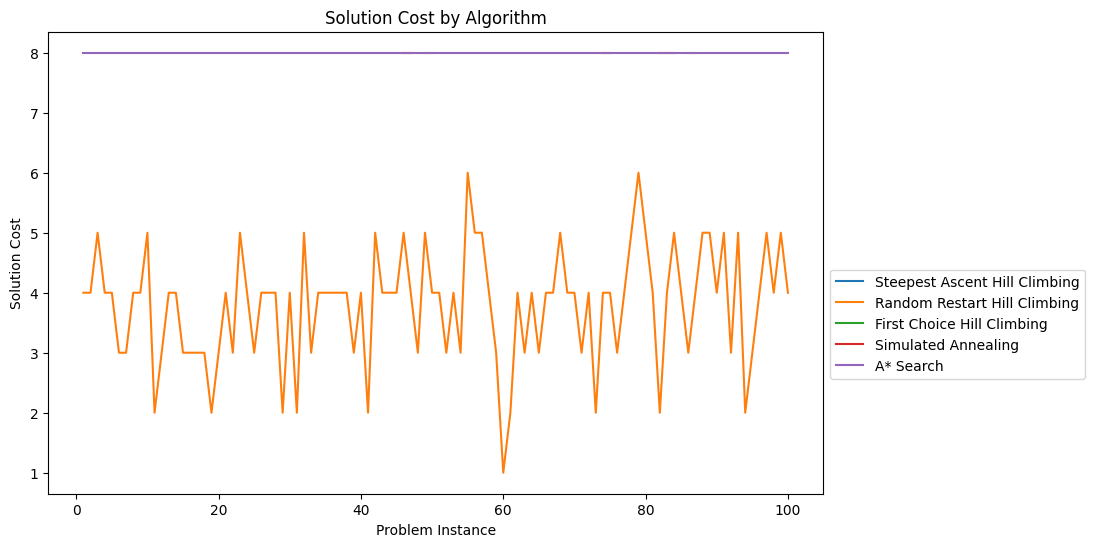

**Figure 1:** Solution Cost by Algorithm

## Average Solution Costs by Algorithm:
Steepest Ascent Hill Climbing: 0.00


Random Restart Hill Climbing: 3.79


First Choice Hill Climbing: 8.00


Simulated Annealing: 8.00


A* Search: 8.00




---

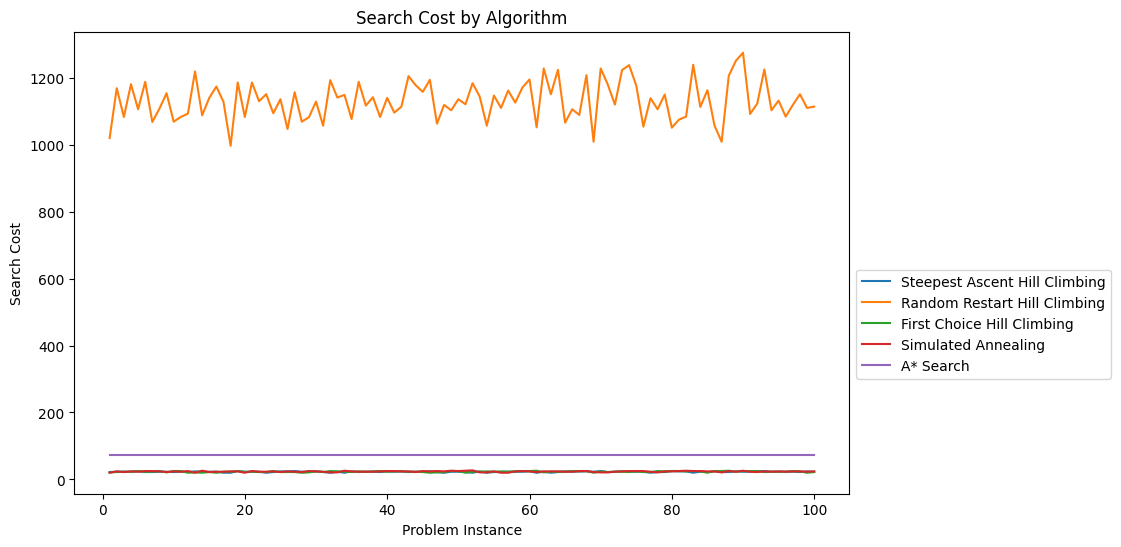

**Figure 2:** Search Cost by Algorithm

## Average Search Costs by Algorithm:
Steepest Ascent Hill Climbing: 22.74


Random Restart Hill Climbing: 1131.12


First Choice Hill Climbing: 23.13


Simulated Annealing: 23.53


A* Search: 72.00




---

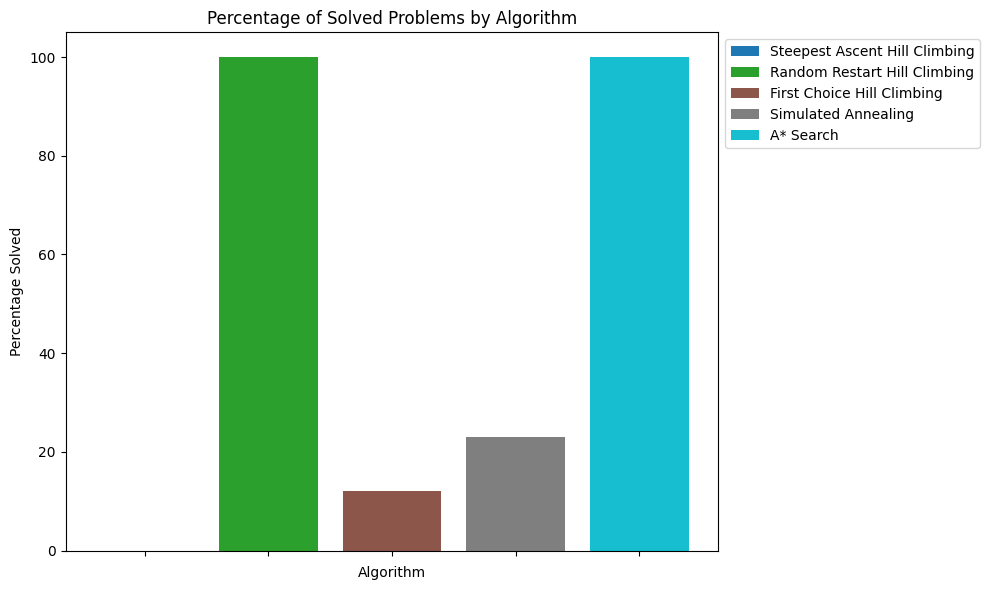

**Figure 3:** Percentage of Solved Problems by Algorithm

## Problems solved by Algorithm:
Steepest Ascent Hill Climbing: 0.0%


Random Restart Hill Climbing: 100.0%


First Choice Hill Climbing: 12.0%


Simulated Annealing: 23.0%


A* Search: 100.0%




---

In [ ]:
solve_report(generate_nqueens_puzzles, 100)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;In **Figure 1**, we can observe that the optimal resolution of the 8-queens puzzle, as found by A* search (A*), requires merely 8 steps. This outcome aligns with expectations, considering that correctly positioning all 8 queens signifies the puzzle's resolution. Both the First-Choice Hill Climbing (FCHC) and Simulated Annealing (SA) approaches similarly reach an 8-step resolution. In contrast, Random Restart Hill Climbing (RRHC) manages to find solutions in fewer than 8 steps. This discrepancy stems from RRHC's ability to 'leap forward' by generating a new, random starting point with queens already positioned, thereby necessitating fewer adjustments to align the queens and reduce conflicts. However, it's crucial to recognize that this reduced step count doesn't accurately reflect the full process of solving the puzzle from an unpopulated board.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Regarding search costs, as depicted in **Figure 2**, RRHC incurs significantly higher costs compared to other algorithms, with costs surpassing others by a factor of 15. This steep increase is attributable to its multiple restarts, each generating various nodes. A* also presents a higher cost, outpacing SA and other hill climbing variants by threefold. This heightened cost arises from A*'s thorough, uniform-cost exploration strategy, which examines a broader range of nodes to ensure an optimal solution, in contrast to the other algorithms, which rely more on luck to stumble upon a solution, thereby reaching it through fewer nodes.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Figure 3** illustrates the success rates of each algorithm. A* boasts a 100% success rate, underscoring its reliability as an optimal and complete algorithm. RRHC also achieves a full success rate. Over many attempts, the likelihood of finding the global maximum increases. Furthermore, RRHC gains an advantage through the creation of new initial states, which allows it to approach the puzzle from a partly solved state and utilize steepest ascent for the remainder. Conversely, standalone Steepest Ascent Hill Climbing (SAHC) fails to solve any puzzles it encounters. This occurs because, after positioning the initial queens, SAHC becomes stuck in a plateau. If an early move proves to be erroneous, SAHC finds itself in a predicament where any subsequent placement of new queens only serves to further diminish its current value. FCHC, however, solves approximately 12% of puzzles by generating new neighbor states until a superior one is found, leveraging the stochastic selection of neighbors for a wider range of potential solutions. SA solves about 23% of puzzles, attributed to its initial phase of high-temperature-induced exploration that permits unfavorable moves, enhancing its problem-solving capability. Nevertheless, as the temperature decreases, making corrections becomes more challenging, potentially leading to a deadlock if too many mistakes were made early on. This nuanced exploration of each algorithm's strengths and limitations offers a comprehensive understanding of their performance in solving the 8-queens puzzle.

Next, we will run the `solve_report` function, using `generate_eight_puzzles` as the input parameter, to address 100 instances of the 8-Puzzle:

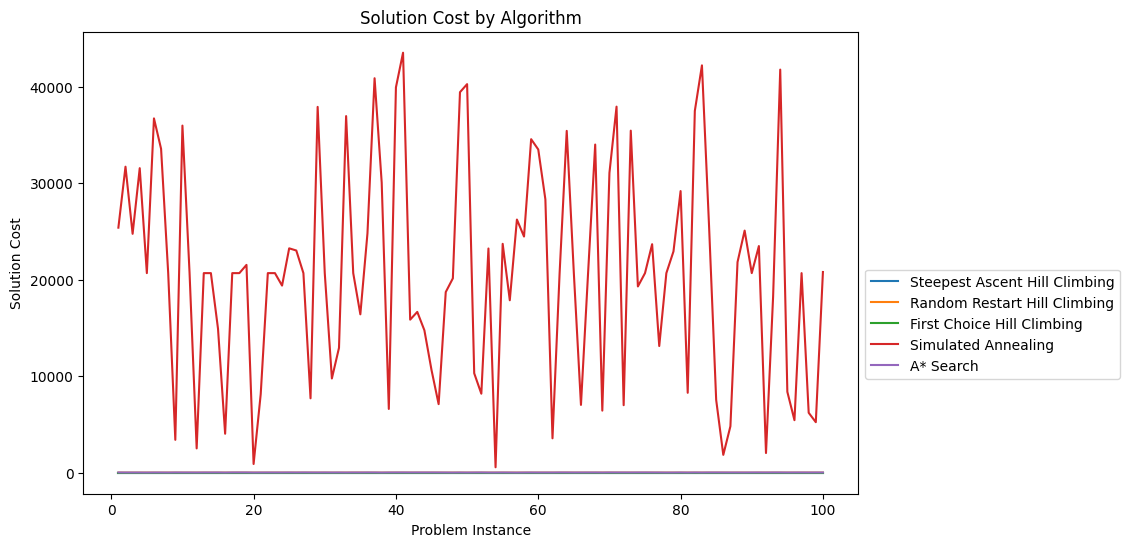

**Figure 4:** Solution Cost by Algorithm

## Average Solution Costs by Algorithm:
Steepest Ascent Hill Climbing: 0.00


Random Restart Hill Climbing: 5.61


First Choice Hill Climbing: 0.00


Simulated Annealing: 20675.66


A* Search: 22.69




---

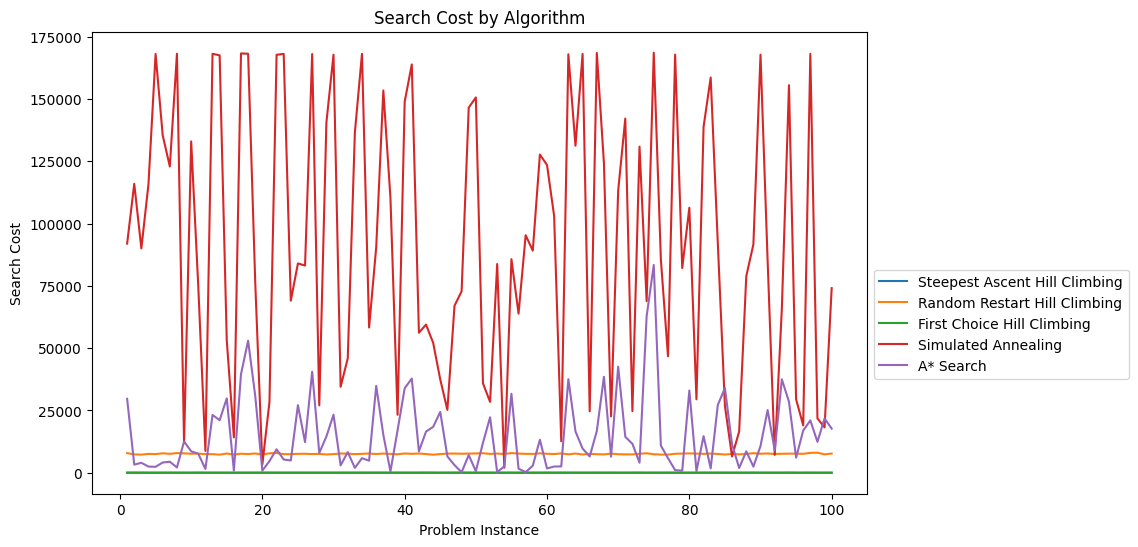

**Figure 5:** Search Cost by Algorithm

## Average Search Costs by Algorithm:
Steepest Ascent Hill Climbing: 8.92


Random Restart Hill Climbing: 7582.69


First Choice Hill Climbing: 8.58


Simulated Annealing: 92057.60


A* Search: 14854.64




---

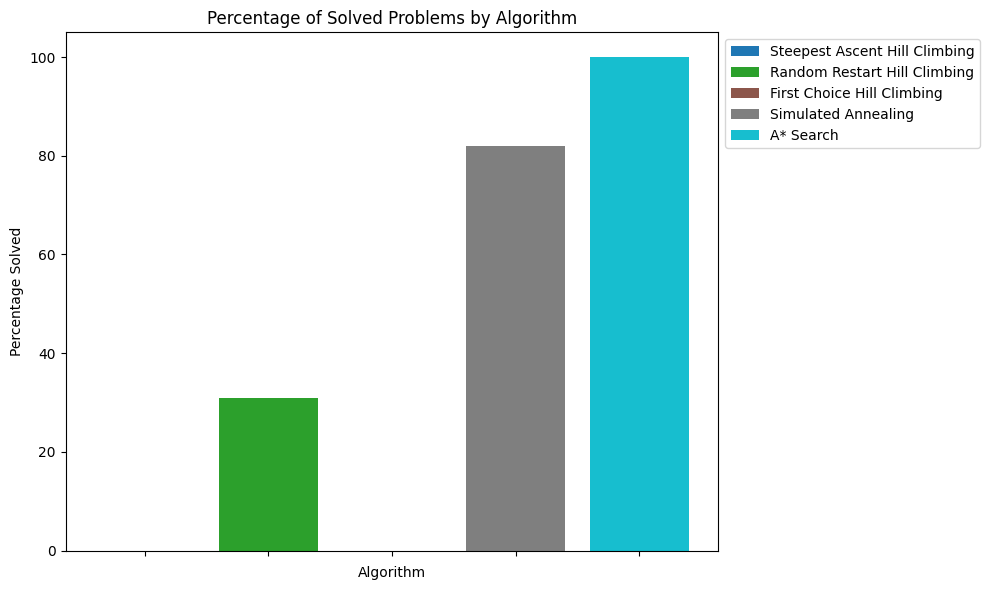

**Figure 6:** Percentage of Solved Problems by Algorithm

## Problems solved by Algorithm:
Steepest Ascent Hill Climbing: 0.0%


Random Restart Hill Climbing: 31.0%


First Choice Hill Climbing: 0.0%


Simulated Annealing: 82.0%


A* Search: 100.0%




---

In [10]:
solve_report(generate_eight_puzzles, 100)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Figure 4** highlights the average solution cost for the 8-Puzzle Problem, measured in moves. The A* search algorithm, known for its optimality and completeness, averages around 23 moves to solve the puzzle. Nevertheless, Random Restart Hill Climbing (RRHC) reports a remarkably lower average, necessitating only 6 moves. This performance of RRHC, however, is attributed to its strategy of generating new initial states that are already closer to the solution, coupled with the use of steepest ascent for swift problem resolution. It's crucial to understand that this method does not tackle the original problem head-on but rather sidesteps it by addressing a less complex variant. Thus, while RRHC appears more efficient, it's important to note that its reduced solution cost does not truly represent the complexity or the direct solving of the initial problem, but rather demonstrates a workaround that bypasses the inherent challenges of the puzzle. With this discrepancy aside, Simulated Annealing (SA) stands out for its significantly higher average solution cost, approximately 900 times that of A*, attributed to its mechanism of accepting less favorable moves while temperature is high. This strategy allows SA to escape local optima and gradually converge on a solution, albeit through a considerably higher number of moves.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Figure 5** delves into the search costs, quantified by the number of nodes generated. Here, SA incurs the highest cost with around 92,000 nodes, a consequence of its continuous exploration and moving of tiles, each generating a new node. A* also has a notable search cost, generating approximately 15,000 nodes, due to its comprehensive search that aims to guarantee an optimal solution. RRHC shows a lower search cost, with about 7,600 nodes, benefiting from its strategy of restarting from states closer to the goal. Remarkably, Steepest Ascent and First Choice Hill Climbing exhibit minimal search costs, with around 9 nodes, yet this can be attributed to their rapid encounter with plateaus, leading to an early termination of the search process.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Figure 6** focuses on the success rates of these algorithms in solving the puzzles. A* consistently solves 100% of the problems, reflecting its optimal and complete nature. SA achieves an 82% success rate, leveraging its ability to navigate through various, and sometimes unfavorable states over time to find solutions. RRHC solves 31% of the problems, its effectiveness limited by the randomness of state generation and the varying proximity of these states to the goal. Steepest Ascent and First Choice Hill Climbing, however, do not successfully solve any of the presented problems due to their tendency to quickly reach a plateau, where no further improvement is possible. This demonstrates the inherent challenge in applying these algorithms to the 8-puzzle problem, where not every move directly improves the solution, highlighting the complexity of algorithmic problem-solving in specific scenarios.

## III. Analysis

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The analysis of the algorithms' performance in solving the 8-queens puzzle and the 8-Puzzle Problem reveals distinct capabilities and limitations inherent to each method. In **Figure 1**, the observation that A* search, First-Choice Hill Climbing (FCHC), and Simulated Annealing (SA) each require 8 steps to resolve the 8-queens puzzle aligns with theoretical expectations, as positioning all 8 queens correctly signifies the puzzle's resolution. The apparent efficiency of Random Restart Hill Climbing (RRHC), which solves the puzzle in fewer than 8 steps, is a result of its unique ability to 'leap forward' by initiating from a partially solved state, necessitating fewer adjustments. However, this reduced step count somewhat misrepresents the complexity of starting from an unpopulated board.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Figure 2** further elaborates on the search costs, showing RRHC's significantly higher costs, over 15 times those of other algorithms. This is attributed to RRHC's frequent restarts and the generation of numerous nodes. Likewise, A* incurs a higher cost than SA and hill climbing variants, due to its exhaustive search strategy, contrasting with the more serendipitous approaches of the latter that incur fewer costs by relying on luck.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The 100% success rate of A* depicted in **Figure 3** underscores its reliability as a complete and optimal algorithm. RRHC also achieves high success rates through its strategic restarts from new initial states. Conversely, SAHC struggles with plateaus, failing to solve any puzzles, while FCHC and SA exhibit moderate success rates, benefiting from stochastic processes and temperature-induced exploration, respectively, offering insights into their problem-solving capabilities.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Figure 4** shifts focus to the 8-Puzzle Problem, showcasing A*'s average solution cost of 23 moves. RRHC reports significantly lower average costs due to its strategy of beginning closer to the solution, bypassing the original problem's complexity. Simulated Annealing stands out for its high solution cost, about 900 times that of A*, attributed to its acceptance of less favorable moves in the short term for a more comprehensive exploration of the solution space. This strategy escapes local optima but at the expense of significantly more moves.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Figure 5** delves into search costs in the context of the 8-Puzzle Problem. SA emerges as the most resource-intensive, with around 92,000 nodes generated, followed by A*'s comprehensive but costly search. RRHC presents a lower cost due to its effective use of restarts, while SA and FCHC display minimal costs due to quickly encountering plateaus that halt further search.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Finally, **Figure 6** addresses the success rates in solving the puzzles, reaffirming A*'s consistency with a 100% success rate. SA's 82% success rate showcases its unique approach to problem-solving, overcoming challenges through a dynamic exploration strategy. RRHC's success is more variable, reflecting the randomness of its restart approach. SA and FCHC, however, fail to solve the puzzles, highlighting the limitations of these methods when faced with complex problem spaces where direct improvements are not always clear.

## VI. Conclusion

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;In this comprehensive exploration of advanced search algorithms, our investigation extended beyond classical search to include nuanced variants of hill climbing and simulated annealing, aiming to uncover the most effective strategies for solving complex problems like the 8-puzzle and N-Queens. By meticulously evaluating these algorithms' search costs and effectiveness, we were able to develop a robust framework for algorithm selection based on their metrics, tailored to meet diverse computational challenges. This endeavor not only broadens our spectrum of problem-solving tools available but also deepens our understanding of how to strategically navigate the vast landscape of algorithmic solutions.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Our analysis, grounded in the methodologies and representations outlined by Norvig and Russell, and leveraging implementations from UC Berkeley, revealed insightful contrasts among the algorithms' performances. Through systematic evaluation and visual representation, we highlighted each method's strengths and limitations in context, offering a clear comparison of their efficiency and success rates. The study revealed that randomness, as employed in Random Restart Hill Climbing, and the stochastic nature of Simulated Annealing significantly contributed to the algorithms' success. Random restarts mitigate the limitations of traditional hill climbing by allowing the algorithm to escape local optima, thus broadening the exploration of the solution space. Similarly, Simulated Annealing's stochastic approach, particularly its acceptance of less favorable moves under certain conditions, facilitates a more comprehensive exploration, enabling it to overcome barriers presented by local optima. These strategies underscore the importance of randomness and stochastic processes in enhancing algorithmic adaptability, thereby increasing the likelihood of discovering optimal or near-optimal solutions.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The insights gleaned from this report underscore the importance of a nuanced approach to algorithm selection, emphasizing the need for a deep understanding of each method's inherent capabilities and limitations. This exploration not only advances our knowledge of search algorithm efficiency and effectiveness but also encourages the adoption of a more critical and informed approach to problem-solving in computer science. As future computer engineers, this project equips us with a comprehensive understanding of these advanced search techniques, paving the way for innovative solutions to emerge in the face of complex computational challenges.

# References

1. S. J. Russell and P. Norvig, Artificial Intelligence: A Modern Approach. Upper Saddle River: Prentice-Hall, 2010. 
3. Aimacode. Aimacode/aima-python: Python implementation of algorithms from Russell and Norvig’s “artificial intelligence - A modern approach.” GitHub. [Online] Available: https://github.com/aimacode/aima-python
